# Challenge

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [8]:
#load packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [9]:
#read in data

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

pd.options.display.max_columns=1000

house_df.head()
#check location variables, yearsold, inflation index, birth rates from census data, events

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [10]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [11]:
house_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
cat = house_df.select_dtypes(['object']).columns

print(cat)
print(len(cat))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
43


In [13]:
num = house_df.select_dtypes(['int64', 'float64']).columns

print(num)
print(len(num))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
38


This dataset contains 43 categorical variables and 38 numeric variables listed above. 

## Dealing with missing data

In [14]:
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum()/house_df.isnull().count()*100).sort_values(ascending=False)

missing = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_missing', 'Percent_missing'])
missing.head(20)

,Total_missing,Percent_missing
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945
garagefinish,81,5.547945


There are 19 variables have missing values, the degree varies from 99.5% to 0.1%. 

## EDA


First, examine the distribution of the target variable *saleprice* and it is positively skewed. So, log transformation is applied. 

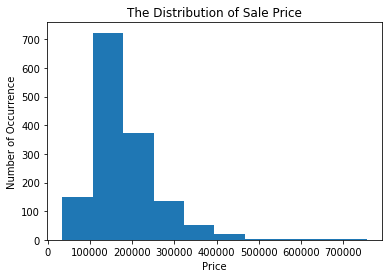

In [21]:
#first, examine the distribution of target variable
plt.hist(house_df['saleprice'])
plt.title('The Distribution of Sale Price')
plt.xlabel('Price')
plt.ylabel('Number of Occurrence')
plt.show()

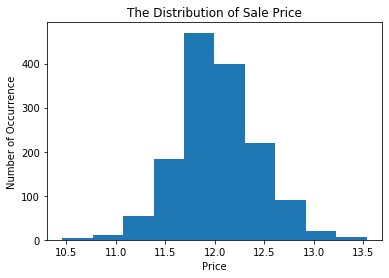

In [22]:
#log transform target variable 
plt.hist(np.log(house_df['saleprice']))
plt.title('The Distribution of Sale Price')
plt.xlabel('Price')
plt.ylabel('Number of Occurrence')
plt.show()

In [23]:
#check if it's normally distributed 

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(house_df['saleprice']))
norm_stats = normaltest(np.log(house_df['saleprice']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 42.7672735832514 and p value is 5.166596039885007e-10
Normality test statistics is 25.507009834238268 and p value is 2.8921658220524008e-06


The p-values indicate that the distribution of the log transformed target variable is statistically different from the normal distribution. However, as it is visually closer to the normal distribution than the orginal data. I will keep the log transformed sale price as the target variable. Then correlations between numeric variables and target variable are examined. 

By examining correlation with target variable, I chose 10 numeric variables that have relative higher correlation with saleprice > 0.50. These features include: overallqual, grlivarea, garagecars, garagearea, totalbsmtsf, firstflrsf, fullbath, totrmsabvgrd, yearbuilt, and yearremodadd. 

In [24]:
abs(house_df[num].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Also, correlations between explantory variables are explored with heatmap. Since garagearea is highly correlated with garagecars (r=0.88), it is removed from the model. In addition, firstflrsf and totrmsabvgrd are removed as they have high correlation with totalbsmtsf and grlivarea, respectively. 

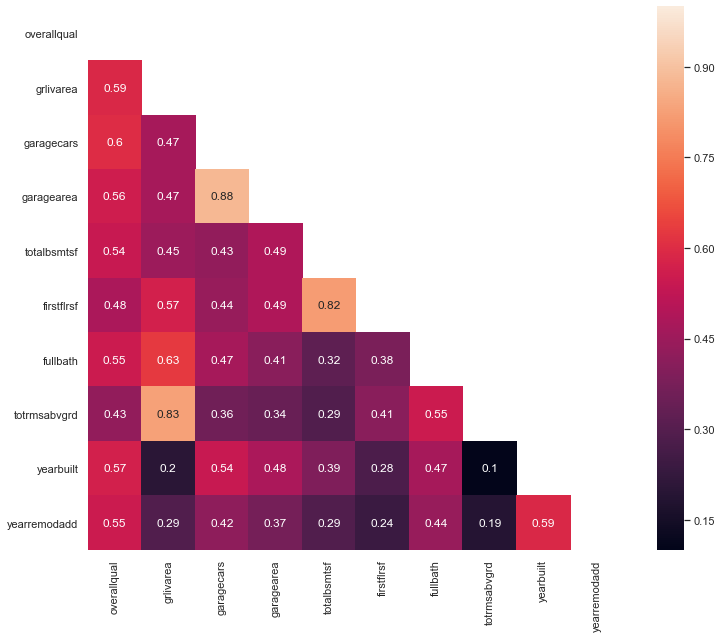

In [25]:
def half_masked_corr_heatmap(dataframe, title=None, file=None):
    
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(dataframe.corr())
    mask [np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        sns.heatmap(dataframe.corr().round(2), mask=mask, annot=True)
        
    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')
    plt.ylabel('')
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    return 

house_var = house_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf',
              'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd']]

half_masked_corr_heatmap(house_var)

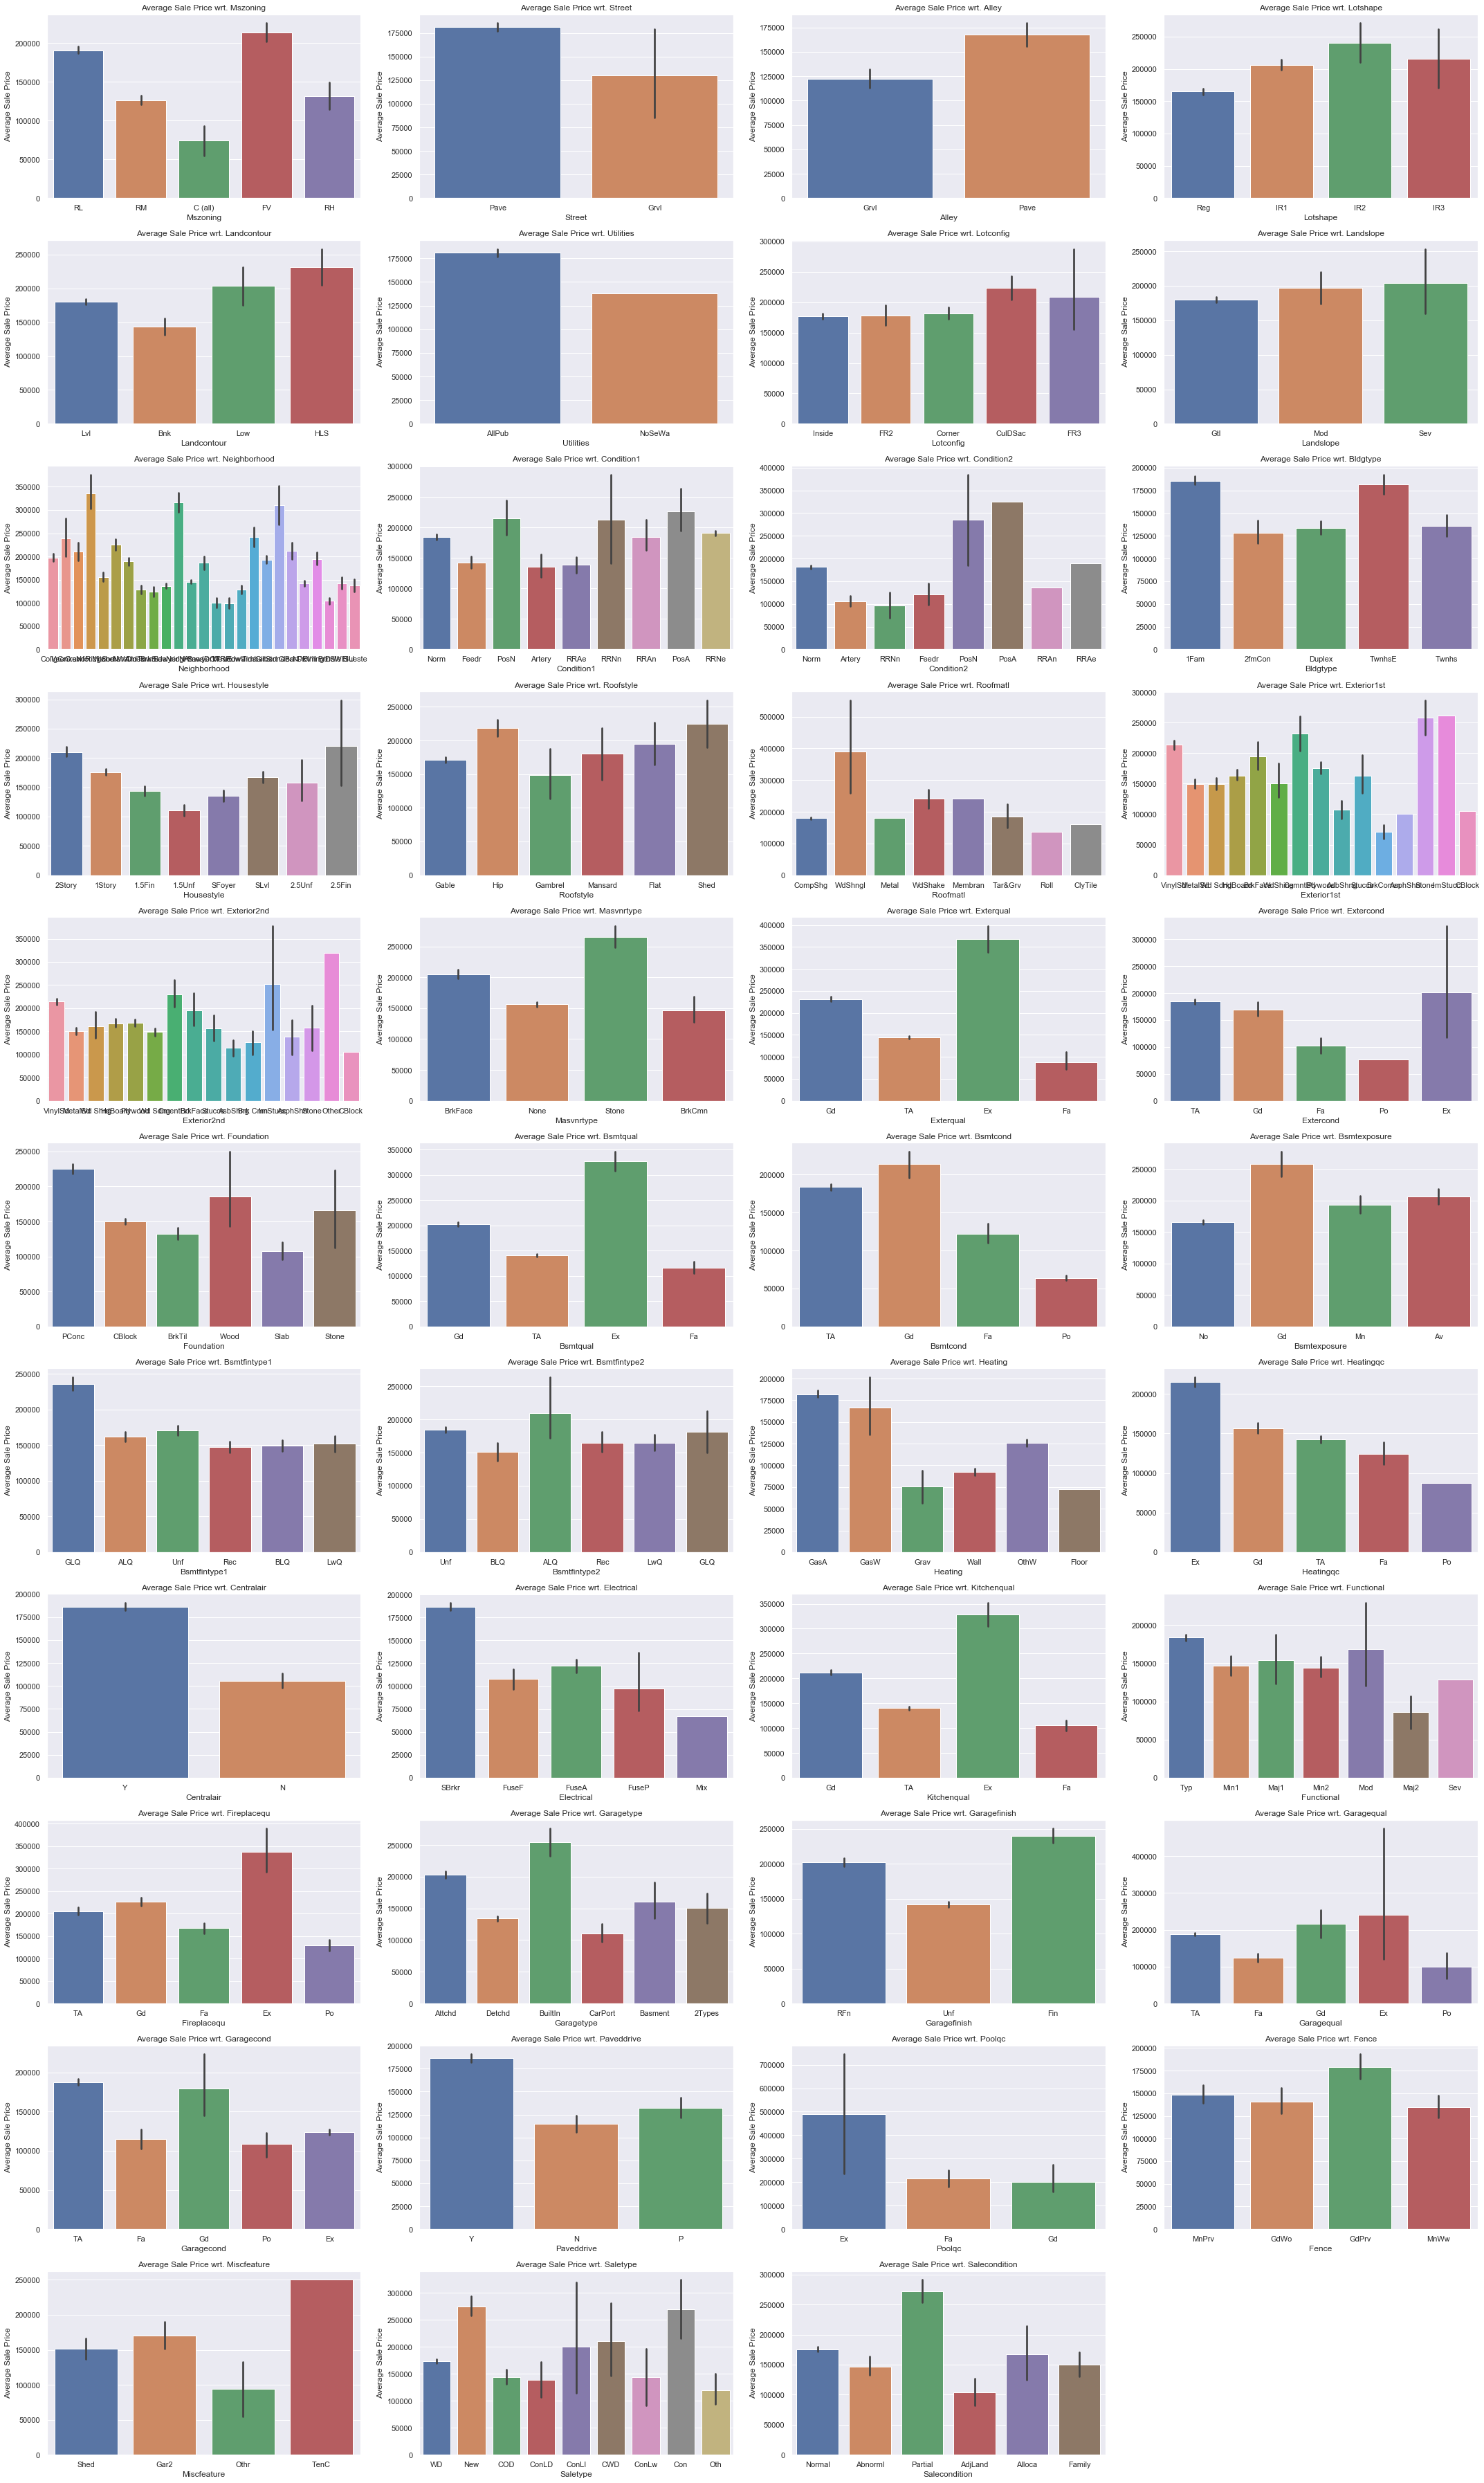

In [26]:
#plot sale price by categorical variables 
plt.figure(figsize=(30,50))

for i in range(len(cat)):
    plt.subplot(11,4,i+1)
    sns.barplot(x=cat[i], y='saleprice', data=house_df)
    plt.title('Average Sale Price wrt. {}'.format(cat[i].capitalize()))
    plt.ylabel('Average Sale Price')
    plt.xlabel('{}'.format(cat[i].capitalize()))

plt.tight_layout()
plt.show()

I also add mszoning and street to the model as I see the target variable varies between those subgroups. 

In [27]:
#convert categorical variable to dummies 
subcat = ['mszoning', 'street']

for i in subcat:
    dummy_column_names = []
    house_df = pd.concat([house_df,
                         pd.get_dummies(house_df[i], prefix=i, drop_first=True)], axis=1
     
                        )

cat_column_names = list(house_df.columns[-5:])

#final data
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,0,0,1,0,1
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,0,0,1,0,1
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,0,1,0,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,0,0,1,0,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,0,0,1,0,1


## Regression Models

The final regression model consists of 9 features. 

In [107]:
Y = np.log(house_df['saleprice'])

X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf',
              'fullbath', 'yearbuilt', 'yearremodadd'] + cat_column_names]

X.head()

,overallqual,grlivarea,garagecars,totalbsmtsf,fullbath,yearbuilt,yearremodadd,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,7,1710,2,856,2,2003,2003,0,0,1,0,1
1,6,1262,2,1262,2,1976,1976,0,0,1,0,1
2,7,1786,2,920,2,2001,2002,0,0,1,0,1
3,7,1717,3,756,1,1915,1970,0,0,1,0,1
4,8,2198,3,1145,2,2000,2000,0,0,1,0,1


In [108]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

The number of observations in the training set is 1168
The number of observations in the test set is 292


In [109]:
#store results here 
rsqr_train = []
mae_train = []
mse_train = []
rmse_train = []

rsqr_test = []
mae_test = []
mse_test = []
rmse_test = []

model = []

In [110]:
#Linear regression model 

lreg = LinearRegression()

lreg.fit(X_train, y_train)

y_preds_train = lreg.predict(X_train)
y_preds_test = lreg.predict(X_test)

rs_train = lreg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = lreg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 1: Linear Regression')

coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(lreg.coef_)
coeff.columns = [['Predictor', 'OLS']]

In [111]:
#Ridge Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import Ridge
print("Ridge Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
RidgeReg = linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
RidgeReg.fit(X_train, y_train)
cv_mse = np.mean(RidgeReg.cv_values_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in RidgeCV: %f" % RidgeReg.alpha_)

#Generate the prediction using the best alpha

alpha = RidgeReg.alpha_
    
ridgeReg = Ridge(alpha=alpha)
ridgeReg.fit(X_train, y_train)

y_preds_train = ridgeReg.predict(X_train)
y_preds_test = ridgeReg.predict(X_test)


rs_train = ridgeReg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ridgeReg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)

rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 2: Ridge Regression')
coeff['Ridge'] = pd.Series(ridgeReg.coef_)

Ridge Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.02875293 0.02874087 0.02875624 0.02903095 0.02956763 0.03480077
 0.04175422 0.04257296 0.04316025 0.04338854 0.04350984 0.04955975
 0.06415945 0.07048755]
Best alpha using built-in RidgeCV: 0.100000


In [112]:
#Lasso Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import Lasso
print("Lasso Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
LassoReg = linear_model.LassoCV(alphas=alphas)
LassoReg.fit(X_train, y_train)
cv_mse = np.mean(LassoReg.mse_path_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in LassoCV: %f" % LassoReg.alpha_)

#Generate the prediction using the best alpha

alpha = LassoReg.alpha_
    
lassoReg = Lasso(alpha=alpha)
lassoReg.fit(X_train, y_train)

y_preds_train = lassoReg.predict(X_train)
y_preds_test = lassoReg.predict(X_test)

rs_train = lassoReg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ridgeReg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 3: Lasso Regression')
coeff['Lasso'] = pd.Series(lassoReg.coef_)

Lasso Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.12775278 0.1246684  0.11792814]
Best alpha using built-in LassoCV: 0.010000


In [113]:
#Elastic Net Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import ElasticNet
print("Elastic Net Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
ENReg = linear_model.ElasticNetCV(alphas=alphas, l1_ratio=0.5)
ENReg.fit(X_train, y_train)
cv_mse = np.mean(ENReg.mse_path_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in RidgeCV: %f" % ENReg.alpha_)

#Generate the prediction using the best alpha

alpha = ENReg.alpha_
    
ENreg = ElasticNet(alpha=alpha, l1_ratio=0.5)
ENreg.fit(X_train, y_train)

y_preds_train = ENreg.predict(X_train)
y_preds_test = ENreg.predict(X_test)

rs_train = ENreg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ENreg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)

rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 4: Elastic Net Regression')
coeff['Elastic Net'] = pd.Series(ENreg.coef_)

Elastic Net Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.12409663 0.12100287 0.11550666]
Best alpha using built-in RidgeCV: 0.010000


In [114]:
print('Coefficient Estimate')

coeff 

Coefficient Estimate


,Predictor,OLS,Ridge,Lasso,Elastic Net
0,overallqual,0.101995,0.102149,0.091662,0.097979
1,grlivarea,0.000228,0.000228,0.000247,0.000232
2,garagecars,0.092552,0.092360,0.061306,0.074276
3,totalbsmtsf,0.000095,0.000094,0.000113,0.000103
4,fullbath,-0.018399,-0.018270,-0.000000,-0.000000
5,yearbuilt,0.000693,0.000700,0.001711,0.001298
6,yearremodadd,0.002342,0.002341,0.002407,0.002376
7,mszoning_FV,0.384827,0.366829,0.000000,0.000000
8,mszoning_RH,0.302135,0.283346,-0.000000,-0.000000
9,mszoning_RL,0.402694,0.385719,0.060698,0.070384


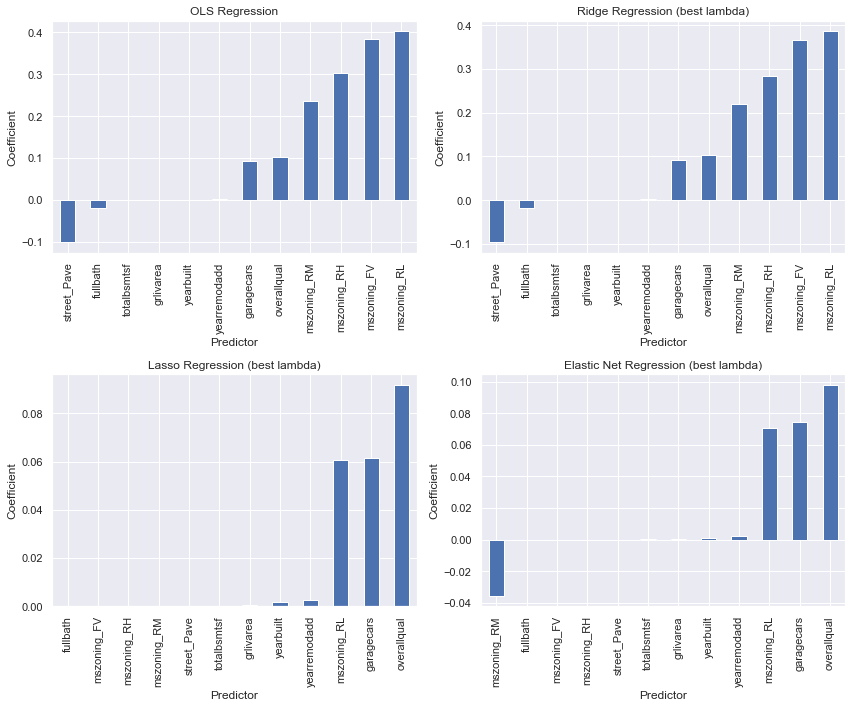

In [115]:
#checking the magnitude of coefficients 

plt.figure(figsize=(12, 10))

predictors = X_train.columns

row=2
col=2

plt.subplot(row,col,1)
coef = pd.Series(lreg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='OLS Regression')
plt.ylabel('Coefficient')
plt.xlabel('Predictor')

plt.subplot(row,col,2)
coef = pd.Series(ridgeReg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Ridge Regression (best lambda)')
plt.ylabel('Coefficient')
plt.xlabel('Predictor')

plt.subplot(row,col,3)
coef = pd.Series(lassoReg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Lasso Regression (best lambda)')
plt.ylabel('Coefficient')
plt.xlabel('Predictor')

plt.subplot(row,col,4)
coef = pd.Series(ENreg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Elastic Net Regression (best lambda)')
plt.ylabel('Coefficient')
plt.xlabel('Predictor')

plt.tight_layout()
plt.show()


In [116]:
data = {'R-squared_train': rsqr_train, 'R-squared_test': rsqr_test, 
        'MAE_train': mae_train, 'MAE_test': mae_test,
        'MSE_train': mse_train, 'MSE_test': mse_test, 
        'RMSE_train': rmse_train, 'RMSE_test': rmse_test}

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics')

table.sort_values(['RMSE_test'], ascending=True)

Summary Statistics


,R-squared_train,R-squared_test,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test
Model 1: Linear Regression,0.833902,0.859177,0.110164,0.113544,0.026174,0.023482,0.161785,0.153238
Model 2: Ridge Regression,0.833889,0.858617,0.110175,0.113664,0.026176,0.023575,0.161791,0.153543
Model 3: Lasso Regression,0.819978,0.858617,0.112085,0.111522,0.028369,0.024187,0.168430,0.155521
Model 4: Elastic Net Regression,0.826088,0.852874,0.111259,0.112475,0.027406,0.024533,0.165547,0.156630


By comparing the results, OLS regression performs the best. 

I found Federal economy data from [Kaggle](https://www.kaggle.com/federalreserve/interest-rates). This could add useful factors to the model. 

In [85]:
#read in data 
econ_df = pd.read_csv('index.csv')
econ_df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [86]:
econ_df.describe()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
count,904.000000,904.000000,904.000000,462.000000,103.000000,103.000000,752.000000,250.000000,752.000000,710.000000
mean,1986.680310,6.598451,3.598451,5.658415,0.308252,0.058252,4.910997,3.138000,5.979122,3.733380
std,17.172843,3.471963,6.791079,2.553891,0.140917,0.140917,3.611431,3.598521,1.567641,2.573637
min,1954.000000,1.000000,1.000000,1.000000,0.250000,0.000000,0.070000,-10.000000,3.400000,0.600000
25%,1973.000000,4.000000,1.000000,3.750000,0.250000,0.000000,2.427500,1.400000,4.900000,2.000000
50%,1987.500000,7.000000,1.000000,5.500000,0.250000,0.000000,4.700000,3.100000,5.700000,2.800000
75%,2001.000000,10.000000,1.000000,7.750000,0.250000,0.000000,6.580000,4.875000,7.000000,4.700000
max,2017.000000,12.000000,31.000000,11.500000,1.000000,0.750000,19.100000,16.500000,10.800000,13.600000


In [87]:
econ_df.columns

Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'Effective Federal Funds Rate', 'Real GDP (Percent Change)',
       'Unemployment Rate', 'Inflation Rate'],
      dtype='object')

Since the housing data is from 2006 to 2010, I filter the econ data by choosing these years and calucating group mean for each variable. 

In [31]:
house_df['yrsold'].describe() 

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: yrsold, dtype: float64

In [91]:
econ = econ_df[econ_df['Year'].isin([2006, 2007, 2008, 2009, 2010])]
econ = econ[['Year', 'Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']]
econ.head()

,Year,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
752,2006,4.9,4.7,2.1
753,2006,NaN,NaN,NaN
754,2006,NaN,4.8,2.1
755,2006,NaN,4.7,2.1
756,2006,NaN,NaN,NaN


In [94]:
econ_final = econ.groupby(['Year'], as_index=False).mean()
econ_final

,Year,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,2006,2.425,4.608333,2.491667
1,2007,1.850,4.616667,2.325000
2,2008,-2.700,5.800000,2.308333
3,2009,-0.175,9.283333,1.691667
4,2010,2.700,9.608333,0.958333


Merge this data with the housing data. And then train models based on previous features adding three economy related features. 

In [98]:
house_df['Year'] = house_df['yrsold']
house_final = house_df.join(econ_final.set_index('Year'), on='Year')
house_final.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,Year,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,0,0,1,0,1,2008,-2.700,5.800000,2.308333
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,0,0,1,0,1,2007,1.850,4.616667,2.325000
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,0,1,0,1,2008,-2.700,5.800000,2.308333
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,0,0,1,0,1,2006,2.425,4.608333,2.491667
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,0,0,1,0,1,2008,-2.700,5.800000,2.308333


In [99]:
house_final.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [117]:
Y = np.log(house_final['saleprice'])

X = house_final[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf',
              'fullbath', 'yearbuilt', 'yearremodadd', 'Real GDP (Percent Change)', 
              'Unemployment Rate', 'Inflation Rate'] + cat_column_names]

X.head()

,overallqual,grlivarea,garagecars,totalbsmtsf,fullbath,yearbuilt,yearremodadd,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,7,1710,2,856,2,2003,2003,-2.700,5.800000,2.308333,0,0,1,0,1
1,6,1262,2,1262,2,1976,1976,1.850,4.616667,2.325000,0,0,1,0,1
2,7,1786,2,920,2,2001,2002,-2.700,5.800000,2.308333,0,0,1,0,1
3,7,1717,3,756,1,1915,1970,2.425,4.608333,2.491667,0,0,1,0,1
4,8,2198,3,1145,2,2000,2000,-2.700,5.800000,2.308333,0,0,1,0,1


In [118]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

The number of observations in the training set is 1168
The number of observations in the test set is 292


In [119]:
#Linear regression model 

lreg = LinearRegression()

lreg.fit(X_train, y_train)

y_preds_train = lreg.predict(X_train)
y_preds_test = lreg.predict(X_test)

rs_train = lreg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = lreg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 5: Linear Regression (econ)')

coeff = pd.DataFrame(X_train.columns)
coeff['OLS(econ)'] = pd.Series(lreg.coef_)

In [120]:
#Ridge Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import Ridge
print("Ridge Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
RidgeReg = linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
RidgeReg.fit(X_train, y_train)
cv_mse = np.mean(RidgeReg.cv_values_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in RidgeCV: %f" % RidgeReg.alpha_)

#Generate the prediction using the best alpha

alpha = RidgeReg.alpha_
    
ridgeReg = Ridge(alpha=alpha)
ridgeReg.fit(X_train, y_train)

y_preds_train = ridgeReg.predict(X_train)
y_preds_test = ridgeReg.predict(X_test)


rs_train = ridgeReg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ridgeReg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)

rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 6: Ridge Regression (econ)')
coeff['Ridge (econ)'] = pd.Series(ridgeReg.coef_)

Ridge Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.0288901  0.02887763 0.0288906  0.02915536 0.02967547 0.03490073
 0.04178661 0.04259098 0.04316809 0.04339364 0.04351401 0.04956045
 0.06415956 0.07048756]
Best alpha using built-in RidgeCV: 0.100000


In [121]:
#Lasso Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import Lasso
print("Lasso Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
LassoReg = linear_model.LassoCV(alphas=alphas)
LassoReg.fit(X_train, y_train)
cv_mse = np.mean(LassoReg.mse_path_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in LassoCV: %f" % LassoReg.alpha_)

#Generate the prediction using the best alpha

alpha = LassoReg.alpha_
    
lassoReg = Lasso(alpha=alpha)
lassoReg.fit(X_train, y_train)

y_preds_train = lassoReg.predict(X_train)
y_preds_test = lassoReg.predict(X_test)

rs_train = lassoReg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ridgeReg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)


rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 7: Lasso Regression (econ)')
coeff['Lasso (econ)'] = pd.Series(lassoReg.coef_)

Lasso Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.12775278 0.1246684  0.11792824]
Best alpha using built-in LassoCV: 0.010000


In [122]:
#Elastic Net Regression: use cross-validation to find the best hyperparameter lambda
from sklearn.linear_model import ElasticNet
print("Elastic Net Regression")
# using the default CV
alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
ENReg = linear_model.ElasticNetCV(alphas=alphas, l1_ratio=0.5)
ENReg.fit(X_train, y_train)
cv_mse = np.mean(ENReg.mse_path_, axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in RidgeCV: %f" % ENReg.alpha_)

#Generate the prediction using the best alpha

alpha = ENReg.alpha_
    
ENreg = ElasticNet(alpha=alpha, l1_ratio=0.5)
ENreg.fit(X_train, y_train)

y_preds_train = ENreg.predict(X_train)
y_preds_test = ENreg.predict(X_test)

rs_train = ENreg.score(X_train, y_train)
ma_train = mean_absolute_error(y_train, y_preds_train)
ms_train = mse(y_train, y_preds_train)
rms_train = rmse(y_train, y_preds_train)


rs_test = ENreg.score(X_test, y_test)
ma_test = mean_absolute_error(y_test, y_preds_test)
ms_test = mse(y_test, y_preds_test)
rms_test = rmse(y_test, y_preds_test)

rsqr_train.append(rs_train)
mae_train.append(ma_train)
mse_train.append(ms_train)
rmse_train.append(rms_train)


rsqr_test.append(rs_test)
mae_test.append(ma_test)
mse_test.append(ms_test)
rmse_test.append(rms_test)


model.append('Model 8: Elastic Net Regression (econ)')
coeff['Elastic Net (econ)'] = pd.Series(ENreg.coef_)

Elastic Net Regression
alphas: [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [0.12409663 0.12100249 0.11550711]
Best alpha using built-in RidgeCV: 0.010000


In [124]:
print('Coefficient Estimate')

coeff 

Coefficient Estimate


,0,OLS(econ),Ridge (econ),Lasso (econ),Elastic Net (econ)
0,overallqual,0.101697,0.101850,0.091662,0.097919
1,grlivarea,0.000228,0.000228,0.000247,0.000232
2,garagecars,0.093154,0.092957,0.061306,0.074297
3,totalbsmtsf,0.000095,0.000094,0.000113,0.000103
4,fullbath,-0.018305,-0.018178,-0.000000,-0.000000
5,yearbuilt,0.000697,0.000703,0.001711,0.001298
6,yearremodadd,0.002340,0.002340,0.002407,0.002378
7,Real GDP (Percent Change),-0.002857,-0.002855,-0.000000,-0.000316
8,Unemployment Rate,-0.006289,-0.006248,-0.000000,-0.000522
9,Inflation Rate,-0.020443,-0.020227,0.000000,0.000000


In [123]:
data = {'R-squared_train': rsqr_train, 'R-squared_test': rsqr_test, 
        'MAE_train': mae_train, 'MAE_test': mae_test,
        'MSE_train': mse_train, 'MSE_test': mse_test, 
        'RMSE_train': rmse_train, 'RMSE_test': rmse_test}

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics')

table.sort_values(['RMSE_test'], ascending=True)

Summary Statistics


,R-squared_train,R-squared_test,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test
Model 5: Linear Regression (econ),0.834118,0.859766,0.109953,0.113253,0.026140,0.023384,0.161680,0.152917
Model 6: Ridge Regression (econ),0.834106,0.859209,0.109975,0.113378,0.026142,0.023477,0.161686,0.153221
Model 1: Linear Regression,0.833902,0.859177,0.110164,0.113544,0.026174,0.023482,0.161785,0.153238
Model 2: Ridge Regression,0.833889,0.858617,0.110175,0.113664,0.026176,0.023575,0.161791,0.153543
Model 3: Lasso Regression,0.819978,0.858617,0.112085,0.111522,0.028369,0.024187,0.168430,0.155521
Model 7: Lasso Regression (econ),0.819978,0.859209,0.112085,0.111522,0.028369,0.024187,0.168430,0.155521
Model 8: Elastic Net Regression (econ),0.826154,0.853049,0.111202,0.112395,0.027395,0.024504,0.165515,0.156537
Model 4: Elastic Net Regression,0.826088,0.852874,0.111259,0.112475,0.027406,0.024533,0.165547,0.156630


As we can see, by adding these three econ features, R-squared increases and errors reduce, especially OLS and Ridge regression. Among all 8 models, the linear regression with econ features performs the best. 